# Lab14: NumPy + OpenCV

## Lab Goals

**Demo1**: Change crying emoji into smiley emoji

**Demo2**: Do histogram equalization on provided image

If you are not using docker containers or devcontainers
```bash
    pip install numpy opencv-python matplotlib  
```

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

## TA demo

real-time line detection

In [2]:
from IPython.display import display, clear_output
import time
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    eroded = cv2.erode(thresh, None, iterations=2)
    dilated = cv2.dilate(eroded, None, iterations=2)
    edges = cv2.Canny(dilated, 100, 200)
    return edges

def apply_roi_mask(edges, width, height):
    vertices = np.array([[
        (0, height), (width//20, 2*height//6),
        (19*width//20, 2*height//6), (width, height)
    ]], dtype=np.int32)

    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    return cv2.bitwise_and(edges, mask)

def classify_lines(lines, width):
    left_lines, right_lines = [], []
    middle_x = width / 2

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        slope = (y2-y1) / (x2 - x1)
        if 0.35 < slope < 0.85 and x1 > middle_x/2:
            right_lines.append(line)
        elif -0.85 < slope < -0.35 and x1 < 3*width/4:
            left_lines.append(line)
    return left_lines, right_lines

def calculate_triangle_area(vertices):
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]
    area = abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)) / 2.0
    return area

In [3]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('car.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    overlay = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)

    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)
    lines = cv2.HoughLinesP(masked, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        left_lines, right_lines = classify_lines(lines, width)

        for line in left_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for line in right_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Triangle detection region: upper 2/3
    mask_tri = np.zeros_like(edges)
    roi_tri = np.array([[(0, 0), (width, 0), (width, 2*height//3), (0, 2*height//3)]], dtype=np.int32)
    cv2.fillPoly(mask_tri, roi_tri, 255)
    edges_tri = cv2.bitwise_and(edges, mask_tri)

    contours, _ = cv2.findContours(edges_tri, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 3:
            area = calculate_triangle_area(approx[:, 0, :])
            if area > 15000:
                centroid = np.mean(approx, axis=0)
                distances = np.linalg.norm(approx[:, 0, :] - centroid, axis=1)
                tip = approx[np.argmax(distances)][0]
                if tip[0] > centroid[0][0]:
                    direction = 'Right'
                    color = (255, 255, 0)   # Blue for right
                else:
                    direction = 'Left'
                    color = (0, 0, 255)   # Red for left

                cv2.drawContours(overlay, [approx], -1, color, 3)
                cv2.putText(overlay, f"Triangle: {direction}", (20, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                break  # Only detect one triangle
    # Display the frame using matplotlib
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Frame")
    plt.axis('off')
    plt.show()

cap.release()

# Demo1

### Step 0. Load Image

replace ```'your_image.jpg'``  with the path to the sad-man image

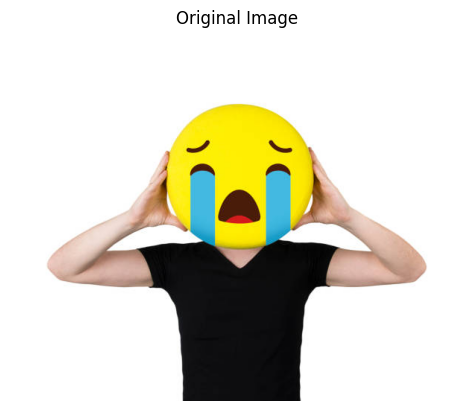

In [4]:
img = cv2.imread('sad_man.jpg')
if img is None:
    raise ValueError("Image not found. Please check the path.")
show_img(img, "Original Image")

### Step 1. Color tracker - yellow

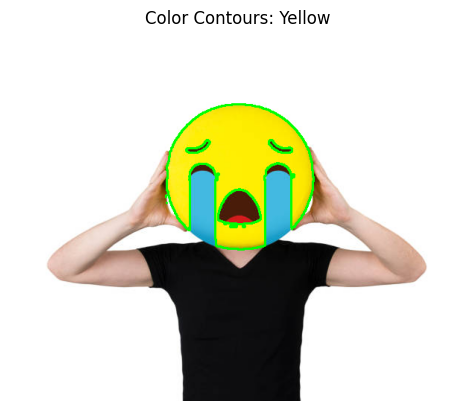

In [5]:
### your code below ### find contours for yellow region
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
edges_tri = cv2.inRange(hsv, (20, 100, 100), (30, 255, 255))   
contours, _ = cv2.findContours(edges_tri, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
### your code above ###
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
show_img(img_contours, "Color Contours: Yellow")

### Step 2. Bound the roi with a box

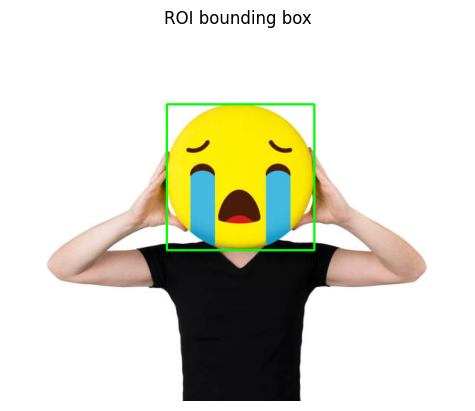

In [6]:
### your code below ###
img_blobs = img.copy()
if contours:
    max_contours = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contours)
    boxes = (x, y, w, h)
    cv2.rectangle(img_blobs, (x, y), (x + w, y + h), (0, 255, 0), 2) 
else:
    boxes = []
    

### your code above ###
show_img(img_blobs, f"ROI bounding box")

### Step 3. Replace crying face with smiley face

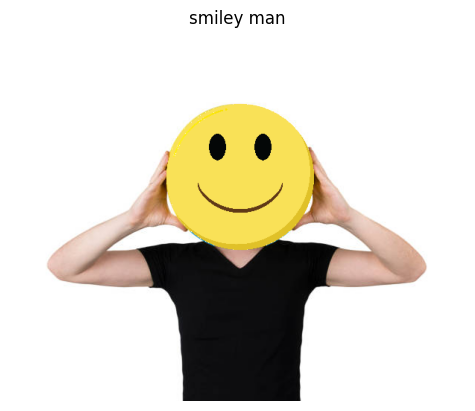

In [7]:
### your code below ### overlay the ROI with smiley face emoji
smile = cv2.imread('smiley_emoji.png')
if smile is None:
    raise ValueError("Image not found. Please check the path.")
smile_gray = cv2.cvtColor(smile, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(smile_gray, 250, 255, cv2.THRESH_BINARY_INV)
mask_inv = cv2.bitwise_not(mask)


if boxes:
    x, y, w, h = boxes
    smile_resized = cv2.resize(smile, (w, h))
    mask_resized = cv2.resize(mask, (w, h))
    mask_inv_resized = cv2.resize(mask_inv, (w, h))
    roi = img[y:y+h, x:x+w]
    img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv_resized)
    smile_fg = cv2.bitwise_and(smile_resized, smile_resized, mask=mask_resized)
    dst = cv2.add(img_bg, smile_fg)
    img[y:y+h, x:x+w] = dst


### your code above ###
show_img(img, "smiley man")

# Demo2

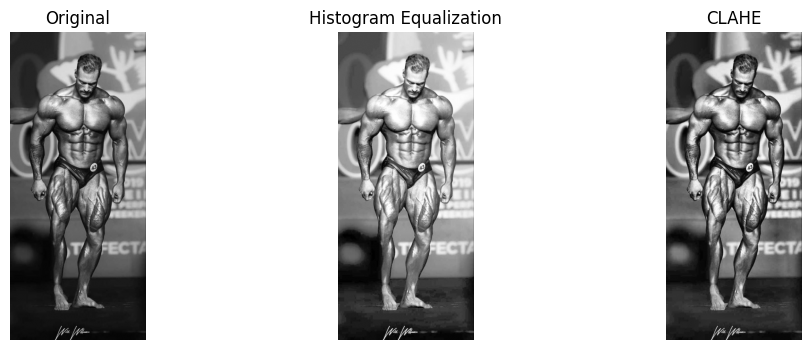

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 載入圖片
img = cv2.imread('cbum.jpg', cv2.IMREAD_GRAYSCALE)

# 傳統直方圖等化
eq = cv2.equalizeHist(img)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

# 顯示結果
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(eq, cmap='gray')
plt.title("Histogram Equalization")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(cl1, cmap='gray')
plt.title("CLAHE")
plt.axis("off")
plt.show()
